In [18]:
from lerobot.common.motors.feetech import FeetechMotorsBus
from lerobot.common.motors import Motor, MotorNormMode
from lerobot.common.motors.motors_bus import MotorCalibration
import time
import joblib
import pandas as pd
from lerobot.common.utils.utils import enter_pressed
from pynput import keyboard
import cv2
import matplotlib.pyplot as plt

In [19]:
calibration = joblib.load("small_robot_calibration.joblib")
motors = [
    "shoulder_pan",
    "shoulder_lift",
    # "elbow_flex",
    "wrist_flex",
    "wrist_roll",
    "gripper",
]

bus = FeetechMotorsBus(
    # port="/dev/tty.usbmodem59700730781",
    # port="/dev/tty.usbmodem5A460817801",
    # port="/dev/tty.usbmodem5A460851571",
    port="/dev/tty.usbmodem5A460851551",
    motors={
        "shoulder_pan": Motor(1, "sts3215", MotorNormMode.RANGE_M100_100),
        "shoulder_lift": Motor(2, "sts3215", MotorNormMode.RANGE_M100_100),
        # "elbow_flex": Motor(3, "sts3215", MotorNormMode.RANGE_M100_100),
        "wrist_flex": Motor(4, "sts3215", MotorNormMode.RANGE_M100_100),
        "wrist_roll": Motor(5, "sts3215", MotorNormMode.RANGE_M100_100),
        "gripper": Motor(6, "sts3215", MotorNormMode.RANGE_M100_100),
    },
    calibration=calibration,
)
bus.connect()
bus.write_calibration(calibration)

In [4]:
pos = {
    "gripper": 0,
}

list(pos.keys())

['gripper']

In [5]:
def set_pos(pos, disable_torque=True):

    for motor, value in pos.items():
        pos[motor] = min(
            max(value, -99.0),
            99.0,
        )

    bus.sync_write(
        data_name="Goal_Position",
        values=pos,
    )
    time.sleep(1)
    if disable_torque:
        bus.disable_torque(list(pos.keys()), False)


def read_pos(verbose=True):
    pos = bus.sync_read(
        data_name="Present_Position",
        motors=motors,
    )
    if verbose:
        print(pos)

    return pos

(800, 1280, 3)

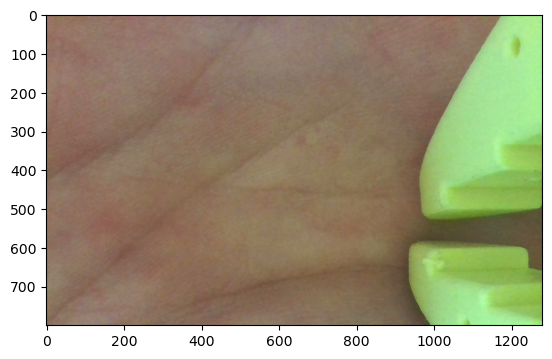

In [6]:
img = cv2.imread("camera_data/1749991198.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

In [7]:
resized_img = cv2.resize(img, (32, 20))

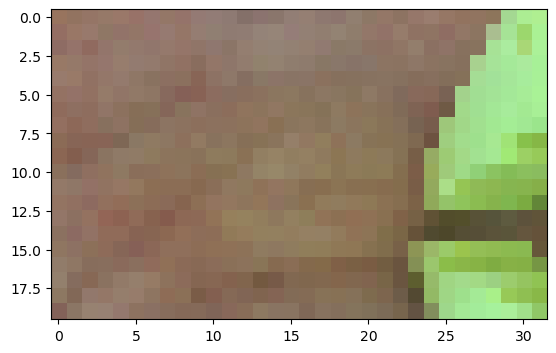

In [8]:
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))

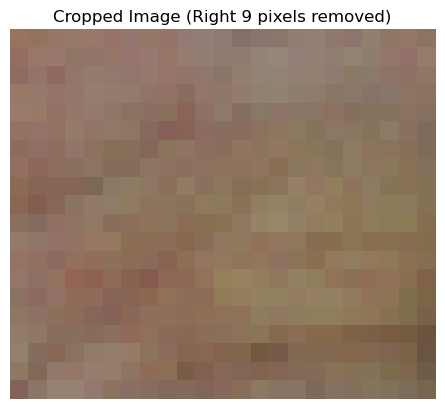

In [9]:
resized_cropped_img = resized_img[:, :-9, :]
plt.imshow(cv2.cvtColor(resized_cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image (Right 9 pixels removed)")
plt.axis("off")
plt.show()

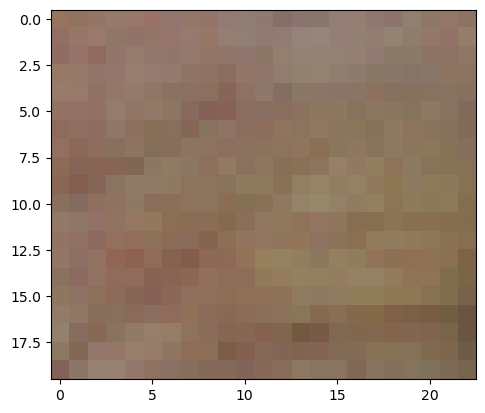

In [10]:
def resize_and_crop_image(image, target_size=(32, 20), crop_right_pixels=9):
    resized_image = cv2.resize(image, target_size)
    cropped_image = resized_image[:, :-crop_right_pixels, :]
    return cropped_image


plt.imshow(cv2.cvtColor(resize_and_crop_image(img), cv2.COLOR_BGR2RGB))

In [11]:
import numpy as np

avg_pixel_hand = np.mean(img, axis=(0, 1)).astype(np.uint8)
print("Average pixel value (BGR):", avg_pixel_hand)

Average pixel value (BGR): [ 96 130 140]


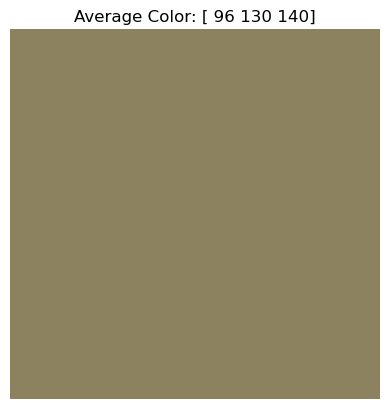

In [12]:
# Create an image filled with the average color
color_img = np.full((100, 100, 3), avg_pixel_hand, dtype=np.uint8)
plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
plt.title(f"Average Color: {avg_pixel_hand}")
plt.axis("off")
plt.show()

In [13]:
def mae(a, b):
    a = np.array(a, dtype=np.float32)
    b = np.array(b, dtype=np.float32)
    return np.mean(np.abs(a - b))


# mae(avg_pixel_hand, avg_pixel)
# mae(resize_and_crop_image(img), resize_and_crop_image(frame))

In [14]:
def add_text_to_image(frame, text):
    cv2.putText(
        frame,
        text,
        (50, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

In [16]:
video_capture = cv2.VideoCapture(0)

while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    avg_pixel = np.mean(frame, axis=(0, 1)).astype(np.uint8)
    bad_img = resize_and_crop_image(frame)
    hand_mae = mae(resize_and_crop_image(img), resize_and_crop_image(frame))
    if hand_mae < 15.0:
        add_text_to_image(frame, f"   hand {hand_mae:.2f}")
        set_pos({"gripper": 30.0})
    else:
        add_text_to_image(frame, f"no hand {hand_mae:.2f}")
        set_pos({"gripper": -90.0})
    cv2.imshow("Camera Feed", bad_img)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

video_capture.release()
cv2.destroyAllWindows()

In [ ]:
read_pos()

In [ ]:
set_pos({"gripper": 30.0})

In [ ]:
set_pos({"gripper": -90.0})

In [ ]:
set_pos(
    {
        "gripper": 0.0,
        "wrist_flex": 0.0,
        "wrist_roll": 0.0,
        "shoulder_pan": 0.0,
        "shoulder_lift": 0.0,
    }
)